In [1]:
from lib.enumerate_anchors_wrapper import AnchorTargetLayer

In [2]:
%matplotlib inline

import chainer
import cv2 as cv
import numpy as np
import six
from matplotlib.patches import Circle



In [3]:
feat_strides = 16
C, W, H = 16, 14, 14   # size of feature map
x = np.arange(1 * C * H * W, dtype=np.float32).reshape(1, C, H, W)

print("original H={} W={}".format(H * feat_strides, W * feat_strides))

im_info = np.array([[224, 224, 0.85]])

original H=224 W=224


In [4]:
anchor_target = AnchorTargetLayer(feat_strides)


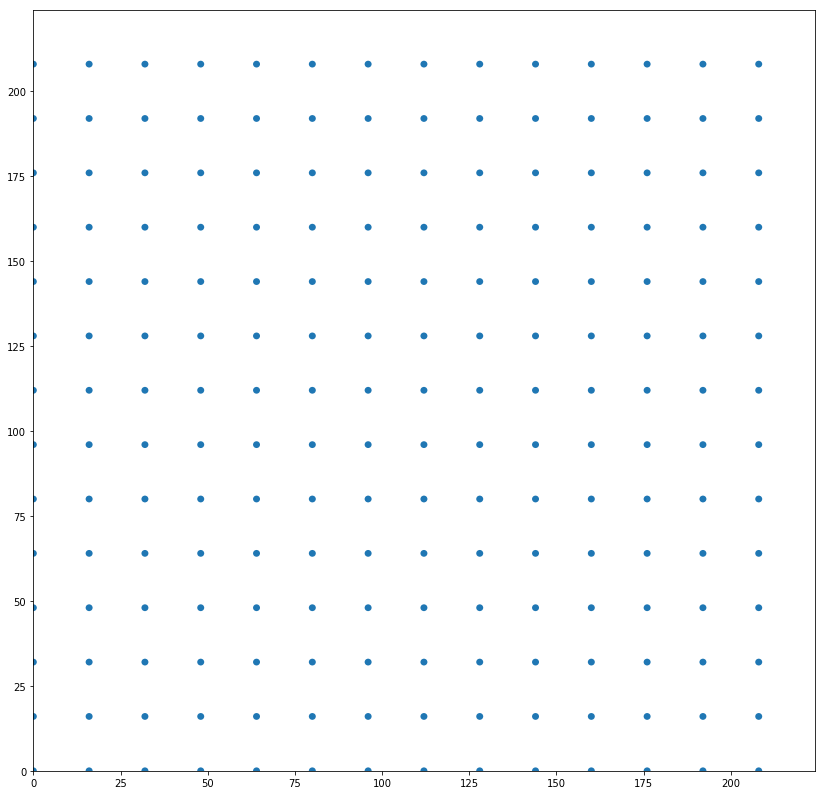

In [5]:
# visualize generaet_shifts
shifts = anchor_target._generate_shifts(W, H)

def vis_shifts(shifts):
    min_x = shifts[:, 0].min()
    min_y = shifts[:, 1].min()
    max_x = shifts[:, 2].max()
    max_y = shifts[:, 3].max()

    shifts = shifts.copy()
    shifts[:, 0] -= min_x
    shifts[:, 2] -= min_x
    shifts[:, 1] -= min_y
    shifts[:, 3] -= min_y

    fig = plt.figure(figsize=(14,14))
    plt.axis([0,224,0,224])
    ax=fig.add_subplot(1,1,1)
    for anchor in shifts:
        anchor = list(six.moves.map(int, anchor))
        circle = plt.Circle((anchor[0], anchor[1]), 1)
        ax.add_patch(circle)
    plt.show()
vis_shifts(shifts)

[-84, -40, 99, 55]
[-176, -88, 191, 103]
[-360, -184, 375, 199]
[-56, -56, 71, 71]
[-120, -120, 135, 135]
[-248, -248, 263, 263]
[-36, -80, 51, 95]
[-80, -168, 95, 183]
[-168, -344, 183, 359]


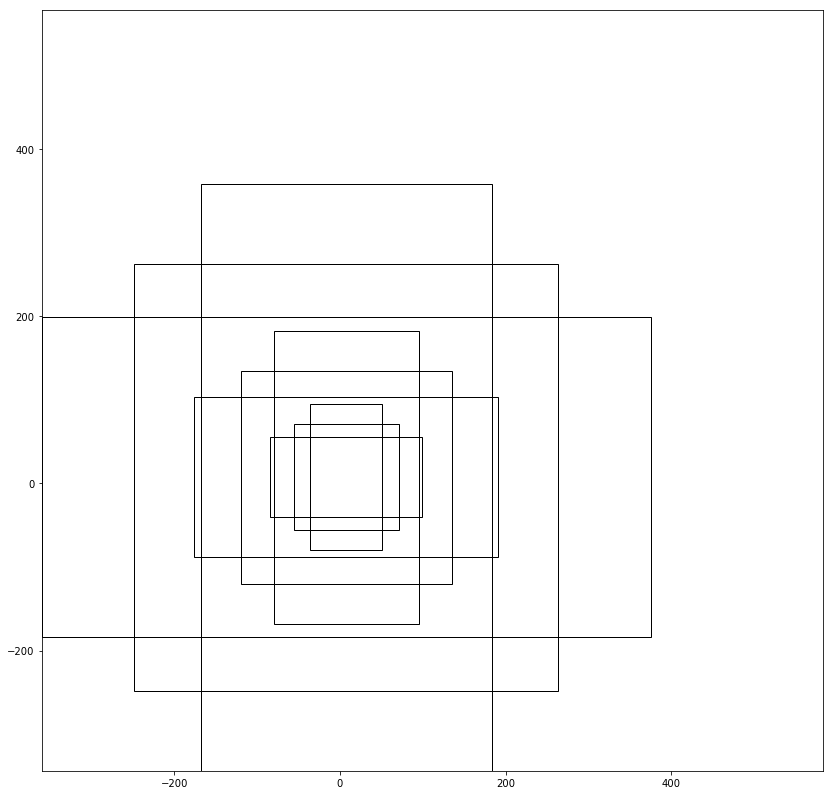

In [6]:
anchors, total_anchors = anchor_target._generate_proposals(shifts)

def vis_anchors(anchors, num=9, verbose=True):
    min_x = anchors[:, 0].min()
    min_y = anchors[:, 1].min()
    max_x = anchors[:, 2].max()
    max_y = anchors[:, 3].max()
    
    anchors = anchors.copy()
    #anchors[:, 0] -= min_x
    #anchors[:, 1] -= min_y
    #anchors[:, 2] -= min_x
    #anchors[:, 3] -= min_y
    min_x = min(min_x, 0)
    min_y = min(min_y, 0)
    max_x = max(max_x, 224)
    max_y = max(max_y, 224)
    
    fig = plt.figure(figsize=(14,14))
    plt.axis([min_x,max_x,min_y,max_y])  # [min_x, max_x, min_y, max_y]
    ax=fig.add_subplot(1,1,1)
    for anchor in anchors[:num]:
        anchor = list(six.moves.map(int, anchor))  # (x, y)
        if verbose:
            print anchor
        rec = plt.Rectangle(
            (anchor[0], anchor[1]),
            anchor[2] - anchor[0], anchor[3] - anchor[1], fill=False)
        ax.add_patch(rec)
    plt.show()
vis_anchors(anchors)

84


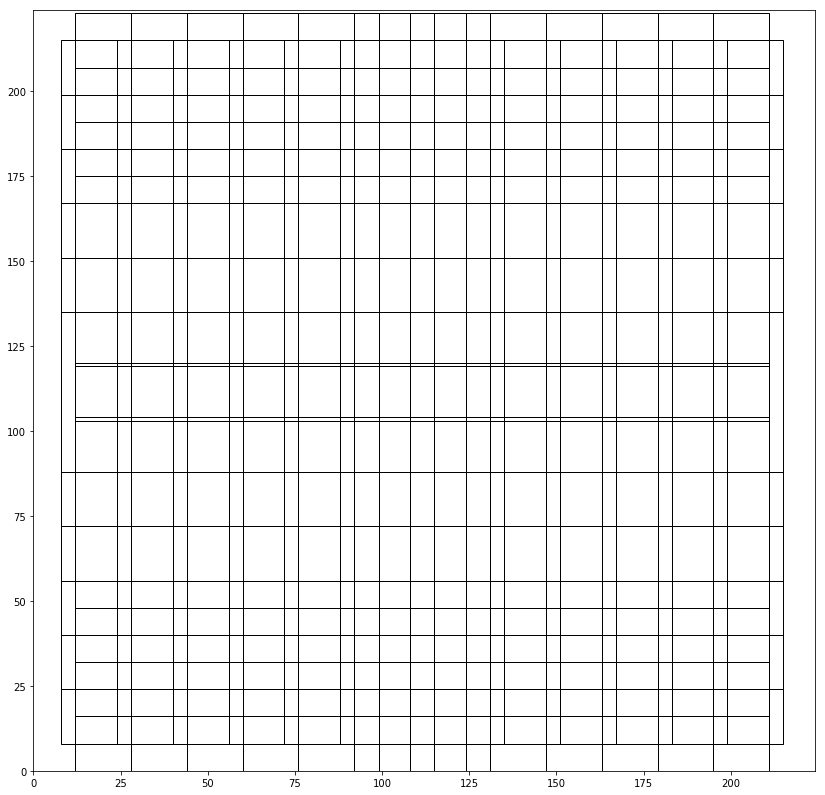

In [7]:
inds_inside, anchors = anchor_target._keep_inside(anchors, im_info)
print len(anchors)
vis_anchors(anchors, num=len(anchors), verbose=False)

[12, 8, 195, 103]
[28, 8, 211, 103]
[8, 8, 135, 135]


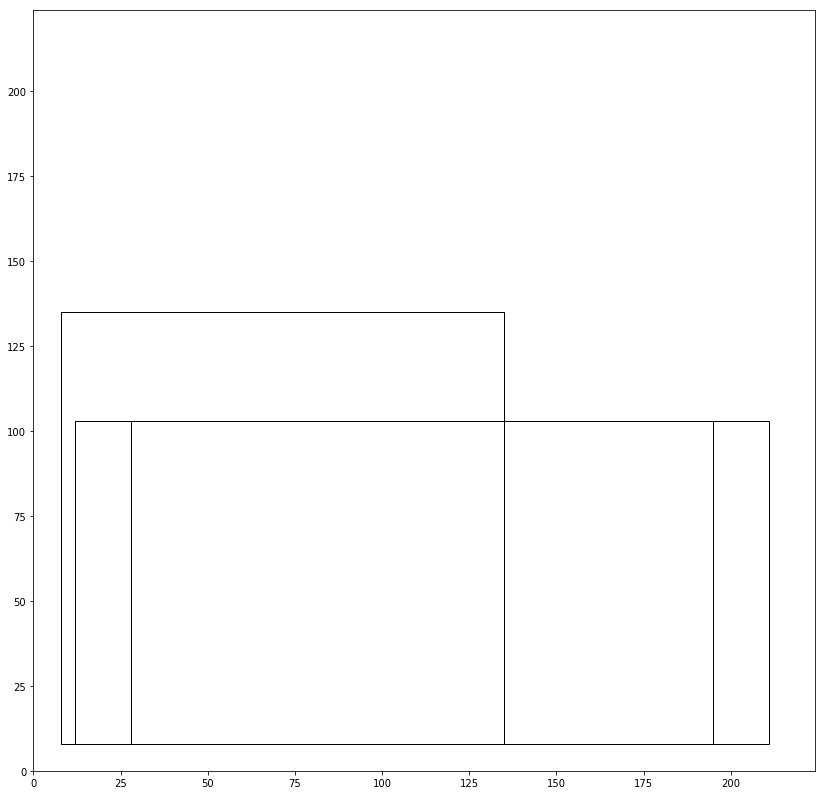

In [8]:
vis_anchors(anchors, num=3)

[10, 10, 60, 200, 0]
[50, 100, 210, 210, 1]
[160, 40, 200, 70, 2]


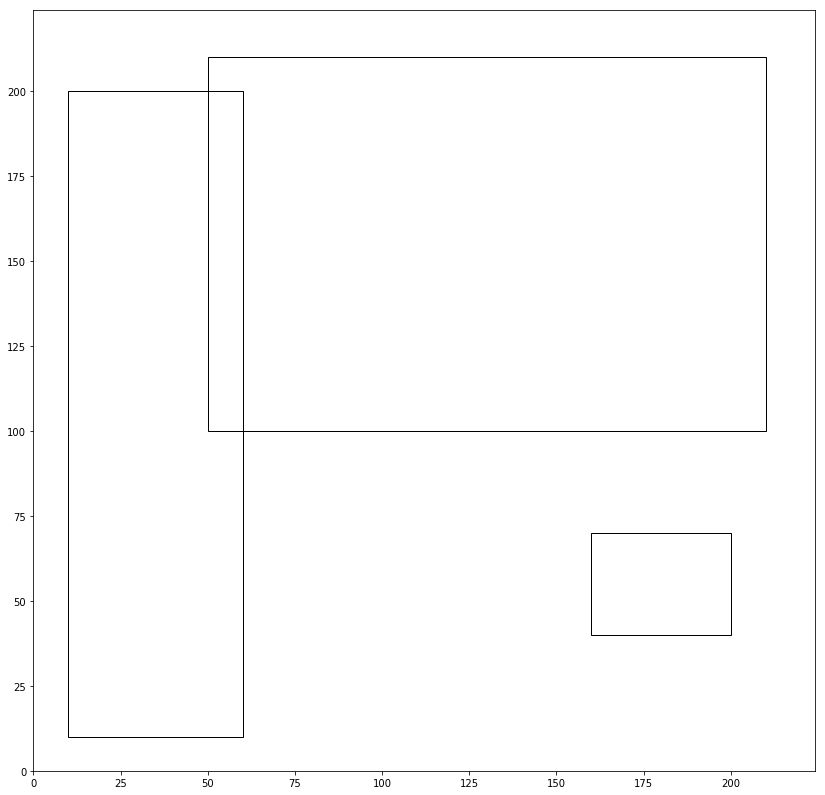

In [9]:
# ground truth boxes
gt_boxes = np.array([
    [10, 10, 60, 200, 0],
    [50, 100, 210, 210, 1],
    [160, 40, 200, 70, 2]
])
vis_anchors(gt_boxes)

In [10]:
anchor_target._calc_overlaps(anchors, gt_boxes, inds_inside)

(array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 0.2020264 ,  0.12763856,  0.32620945,  0.21721101,  0.20721554,
         0.14156697,  0.13070925,  0.15542888,  0.15542888,  0.1484561 ,
         0.47581164,  0.33311221,  0.27735305,  0.22142223,  0.22973421,
         0.20721554,  0.21821544,  0.25075925,  0.19489559,  0.24116816,
         0.25075925,  0.24116816,  0.25075925,  0.22958469,  0.25075925,
         0.24720529,  0.51936164,  0.33311221,  0.29905772,  0.25388923,
         0.2922332 ,  0.27169595,  0.3058976 ,  0.32046867,  0.30821338,
         0.34065203,  0.32046867,  0.34065203,  0.32046867,  0.32304662,
         0.32046867,  0.31567738,  0.48861223,  0.33311221,  0.28378791,
         0.33355394,  0.36142513,  0.38770649,  0.4071807

8
[124, 0, 211, 175]
[12, 16, 99, 191]
[124, 16, 211, 191]
[124, 32, 211, 207]
[28, 104, 211, 199]
[56, 88, 183, 215]
[72, 88, 199, 215]
[28, 120, 211, 215]


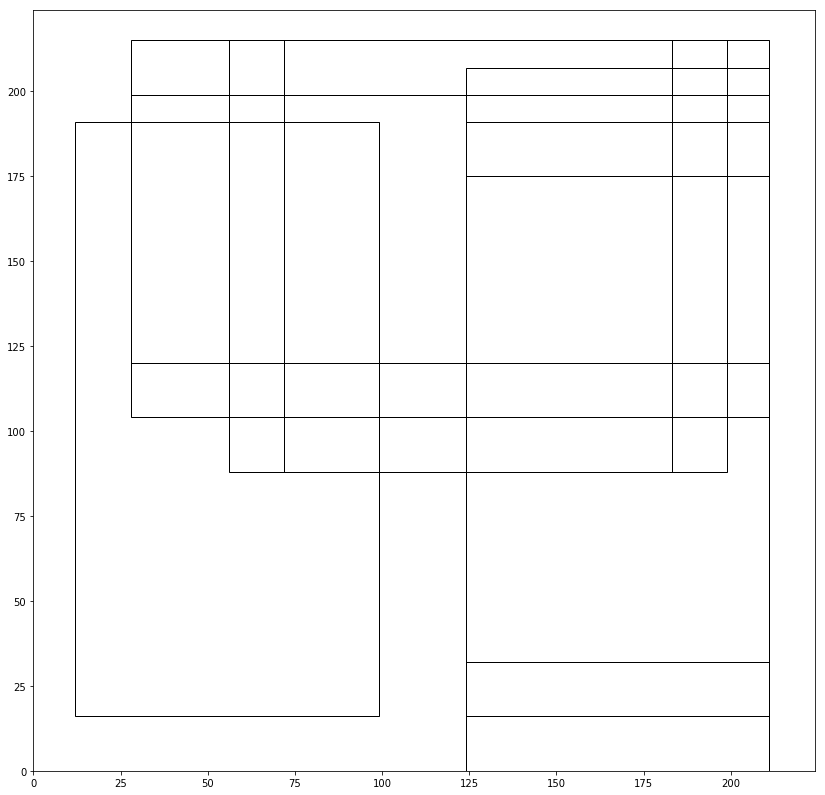

In [11]:
# create labels
# print len(anchors)
argmax_overlaps, labels = anchor_target._create_labels(inds_inside, anchors, gt_boxes)

pos_ids = np.where(labels == 1)[0]
pos_anchors = anchors[pos_ids]
print len(pos_anchors)
vis_anchors(pos_anchors)

In [13]:
feature_shape = (14, 14)
labels, bbox_targets, bbox_inside_weights, bbox_outside_weights = anchor_target(feature_shape, gt_boxes, im_info)

In [21]:
np.unique(labels)

array([-1,  0,  1], dtype=int32)